# Diffusion for a Toy SU(2) model

In this notebook, we look at a toy matrix model defined in terms of a single ${\rm SU}(2)$ degree of freedom occupying a single site on a zero dimensional lattice. The toy action we work with is given by $$S[U] = -\frac{\beta}{2} {\rm Re}{\rm Tr}(U),$$ where $\beta$ is a coupling strength.

The diffusion model setup will be entirely Euclidean in the variance-expanding picture. Our approach will be to take pre-generated configurations $U$, project them into the Lie Algebra, and extract the 3 coefficients on the group generators to use as diffusion data.

$$U \xrightarrow{\log} A = \sum_j c_j \sigma_j \xrightarrow{\langle \sigma_j, \cdot\rangle} \left\{c_j\right\}_{j=1, 2, 3}$$
Then we "do" the diffusion (training and sampling in the usual way) to obtain new generator coefficients, then recompose these coefficients into new ${\rm SU}(2)$ matrices:

$$ \left\{c_j'\right\}_{j=1, 2, 3} \xrightarrow{\text{recombine}} \sum_j c_j' \sigma_j = A' \xrightarrow{\text{exponentiate}} \exp(iA') = U'$$

In [1]:
# General imports
import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Imports from our repo
import sys
sys.path.insert(0, '../src/')  # repo source code

from linalg import trace, adjoint
from action import SUNToyAction
from diffusion import VarianceExpandingDiffusion
from sun import (
    proj_to_algebra, 
    random_sun_element,
    group_to_coeffs, coeffs_to_group
)

from utils import grab
from devices import set_device, get_device, summary

In [3]:
# Set a device
import devices  # from our src code

devices.set_device('cpu')
print(devices.summary())

Using device: cpu (CPU) with dtype: torch.float64


## Generate training data

For this example, we will try to learn a target density defined by our simple toy action. To learn this density through a diffusion model, we require training data. We will generate training configs by the Metropolis algorithm.

In [4]:
# Instantiate and test a toy SU(2) matrix action
def _test_action():
    batch_size = 3
    Nc = 2
    U = random_sun_element(batch_size, Nc=2)

    action = SUNToyAction(beta=1.0)
    print('Action evaluated on configs:', grab(action(U)))

_test_action()

Action evaluated on configs: [-0.37245256  0.68913517 -0.40936934]


In [5]:
def apply_metropolis(batch_size, Nc, action, num_steps, step_size):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    U = random_sun_element(batch_size, Nc=Nc)
    for _ in range(num_steps):
        # Proposal
        V_re = torch.eye(Nc).repeat(batch_size, 1, 1) 
        V_im = step_size * torch.randn((batch_size, Nc, Nc))
        V = V_re + 1j*V_im
        V = torch.matrix_exp(1j*proj_to_algebra(V))  # random group noise
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand((batch_size,))  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))

    return U, action_vals, accept_rates

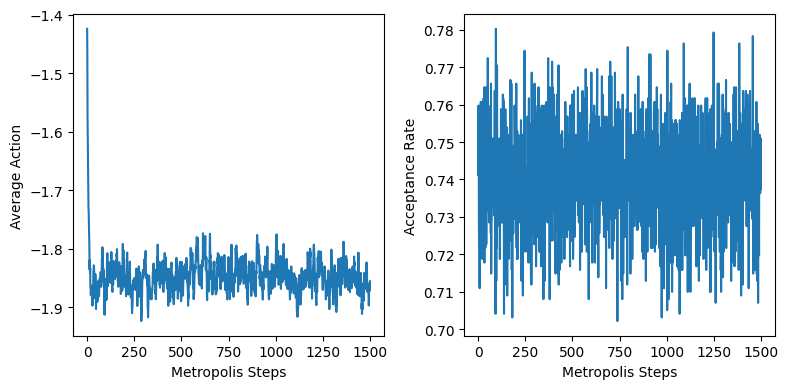

In [6]:
# Define physical theory
beta = 3.5
action = SUNToyAction(beta)


# Generate samples
num_train = 2 ** 10
num_therm = 500
num_iters = 1_000
step_size = 0.9

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = num_train,
    Nc = 2,
    action = action,
    num_steps = num_therm + num_iters,
    step_size = step_size
)


# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(action_vals)
axes[0].set_ylabel('Average Action')

axes[1].plot(accept_rates)
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
fig.show();

## Build a score network

First we will build a simple score network that acts on the generator coefficients.

*Note:* There are two score network implementations worth testing: one with and one without time-dependence (see below)

In [7]:
# First: NO time dependence
class SimpleScoreNetSU2(torch.nn.Module):
    """Time-independent MLP score network for SU(2) generator coefficients."""
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 3)
        )

    def forward(self, x, t=None):
        """
        Forward pass. 

        Args:
            x (Tensor): Coefficients of Lie group generators
            t (Tensor, optional): Time step
        """
        del t
        return self.net(x)

        
def _test_su2_score_net():
    score_net = SimpleScoreNetSU2()
    U = random_sun_element(batch_size=5, Nc=2)
    x = group_to_coeffs(U).real
    out = score_net(x)
    assert x.shape == out.shape, \
        '[FAILED: Network output must have same shape as input]'
    print('[PASSED]')


_test_su2_score_net()

[PASSED]


In [8]:
# With time dependence (no embedding)
class TimeDependentScoreNetSU2(torch.nn.Module):
    """Time-dependent MLP score network for SU(2) generator coefficients."""
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(4, 8),  # 3 su2 gens + 1 time
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 3)
        )

    def forward(self, x, t):
        """
        Forward pass. 

        Args:
            x (Tensor): Coefficients of Lie group generators
            t (Tensor): Time step
        """
        t = t.unsqueeze(-1)
        x = torch.cat([x, t], dim=-1)
        return self.net(x)


def _test_su2_score_net():
    score_net = TimeDependentScoreNetSU2()
    U = random_sun_element(batch_size=5, Nc=2)
    x = group_to_coeffs(U).real
    t = torch.rand((x.shape[0],))
    out = score_net(x, t)
    assert x.shape == out.shape, \
        '[FAILED: Network output must have same shape as input]'
    print('[PASSED]')


_test_su2_score_net()

[PASSED]


## Train the diffusion model

We will train our score network using the traditional score matching loss function.

In [9]:
def score_matching_loss(x_0, score_net, diffuser, tol=1e-5):
    t = torch.rand((x_0.shape[0],))
    t = (1 - tol) * t + tol  # avoid endpoints where score can become unstable
    x_t = diffuser(x_0, t)
    
    sigma_t = diffuser.sigma_func(t)[:, None]
    score = score_net(x_t, t) / sigma_t
    eps = (x_t - x_0) / sigma_t
    loss = torch.sum((score*sigma_t + eps)**2, dim=-1)
    return loss.mean()

In [10]:
# Make diffuser
sigma = 25
diffuser = VarianceExpandingDiffusion(sigma)


# Make a score net
#score_net = SimpleScoreNetSU2()
score_net = TimeDependentScoreNetSU2()


# Training hyperparams
num_epochs = 1_000
lr = 1e-2
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)


# Prepare data
x_0 = group_to_coeffs(U_train).real


# Training loop
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    loss = score_matching_loss(x_0, score_net, diffuser)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch} / {num_epochs} | Loss = {loss.item():.6f}')
    losses.append(loss.item())

Epoch 0 / 1000 | Loss = 2.832211
Epoch 1 / 1000 | Loss = 2.722602
Epoch 2 / 1000 | Loss = 2.454056
Epoch 3 / 1000 | Loss = 2.500499
Epoch 4 / 1000 | Loss = 2.448281
Epoch 5 / 1000 | Loss = 2.429977
Epoch 6 / 1000 | Loss = 2.325087
Epoch 7 / 1000 | Loss = 2.137099
Epoch 8 / 1000 | Loss = 2.114679
Epoch 9 / 1000 | Loss = 2.145075
Epoch 10 / 1000 | Loss = 1.976301
Epoch 11 / 1000 | Loss = 1.986026
Epoch 12 / 1000 | Loss = 2.038233
Epoch 13 / 1000 | Loss = 1.905358
Epoch 14 / 1000 | Loss = 1.911216
Epoch 15 / 1000 | Loss = 1.875799
Epoch 16 / 1000 | Loss = 1.895145
Epoch 17 / 1000 | Loss = 1.852678
Epoch 18 / 1000 | Loss = 1.692576
Epoch 19 / 1000 | Loss = 1.697482
Epoch 20 / 1000 | Loss = 1.798850
Epoch 21 / 1000 | Loss = 1.572073
Epoch 22 / 1000 | Loss = 1.656678
Epoch 23 / 1000 | Loss = 1.553339
Epoch 24 / 1000 | Loss = 1.525876
Epoch 25 / 1000 | Loss = 1.596976
Epoch 26 / 1000 | Loss = 1.513417
Epoch 27 / 1000 | Loss = 1.418113
Epoch 28 / 1000 | Loss = 1.484391
Epoch 29 / 1000 | Loss =

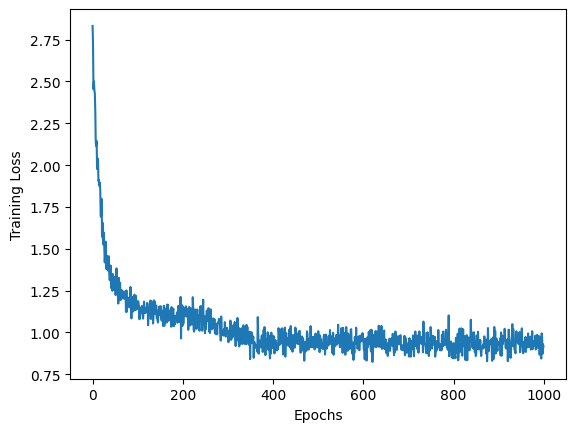

In [11]:
# Plot training loss over time
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss')
fig.show();

## Sample new generator coefficients from the trained model

Now we will use simple numerical integration to execute the reverse (denoising) process and recover new data samples

In [12]:
num_samples = 2 ** 10
num_steps = 200

new_action_vals = []
with torch.no_grad():
    # Sample noisy prior data
    prior_sigma = diffuser.sigma_func(t=1.0)
    x_1 = prior_sigma * torch.randn((num_samples, 3))

    # Solve the SDE with Euler-Maruyama
    dt = 1 / num_steps
    times = torch.linspace(1.0, dt, num_steps)
    
    x_t = x_1.clone()
    for i, t in enumerate(times):
        t = t.repeat(num_samples,)
        noise = torch.randn_like(x_0)
        g_t = diffuser.noise_coeff(t)[:, None]
        score = score_net(x_t, t) / diffuser.sigma_func(t)[:, None]
        
        x_t = x_t + g_t**2 * score * dt + g_t * noise * dt**0.5  # Euler-Maruyama
        #x_t = x_t + 0.5 * g_t**2 * score * dt  # Euler
        
        S = action(coeffs_to_group(x_t))
        new_action_vals.append(S.mean().item())
        if i % 10 == 0:
            print(f'Step {i} / {num_steps} | Action = {S.mean().item():.6f}')

Step 0 / 200 | Action = -0.037264
Step 10 / 200 | Action = 0.048733
Step 20 / 200 | Action = -0.098066
Step 30 / 200 | Action = 0.063013
Step 40 / 200 | Action = 0.095149
Step 50 / 200 | Action = 0.242215
Step 60 / 200 | Action = 0.506924
Step 70 / 200 | Action = 1.074475
Step 80 / 200 | Action = 1.306395
Step 90 / 200 | Action = 1.340827
Step 100 / 200 | Action = 1.204825
Step 110 / 200 | Action = 0.972744
Step 120 / 200 | Action = 0.542694
Step 130 / 200 | Action = 0.193006
Step 140 / 200 | Action = -0.156464
Step 150 / 200 | Action = -0.526644
Step 160 / 200 | Action = -0.839145
Step 170 / 200 | Action = -1.134591
Step 180 / 200 | Action = -1.435178
Step 190 / 200 | Action = -1.726356


## Validation and Visualization

To compare our samples, we will look at the average value of the action on the different batches of configurations as well as the density of the eigenangle $\theta$ where $\lambda = e^{i\theta}$.

In [13]:
U_prior = coeffs_to_group(x_1)
U_new = coeffs_to_group(x_t)

S_prior = action(U_prior).mean().item()
S_train = action(U_train).mean().item()
S_new = action(U_new).mean().item()
print('Action on U_prior:', S_prior)
print('Action on U_train:', S_train)
print('Action on U_new:', S_new)

Action on U_prior: 0.07287195068928692
Action on U_train: -1.8556069954033911
Action on U_new: -2.1198422006068895


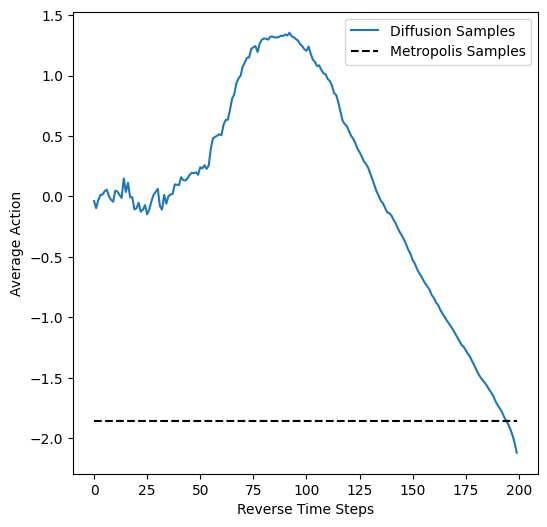

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlabel('Reverse Time Steps')
ax.set_ylabel('Average Action')
ax.plot(new_action_vals, label='Diffusion Samples')
ax.hlines(S_train, xmin=0, xmax=num_steps-1, ls='--', color='black', label='Metropolis Samples')
ax.legend()
fig.show();

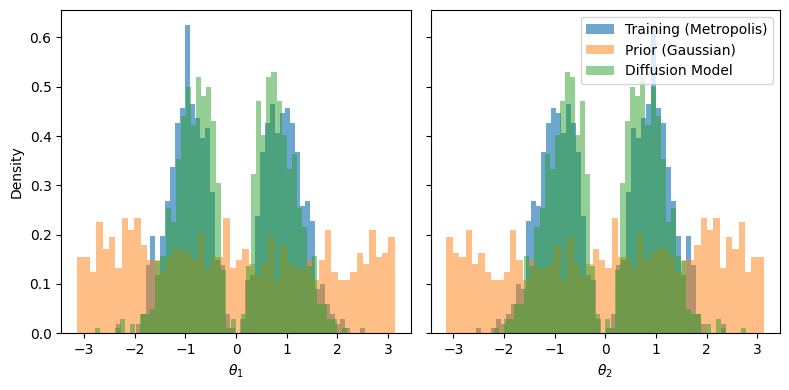

In [15]:
# Training data (Metropolis)
D_train, _ = torch.linalg.eig(U_train)
th_train = torch.angle(D_train)

# Prior data (Gaussian)
D_prior, _ = torch.linalg.eig(U_prior)
th_prior = torch.angle(D_prior)

# Posterior data (Diffusion)
D_new, _ = torch.linalg.eig(U_new)
th_new = torch.angle(D_new)

# plot angular densities
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes[0].set_ylabel('Density')
for i, ax in enumerate(axes):
    ax.hist(grab(th_train[:, i]), bins=50, density=True, alpha=0.65, label='Training (Metropolis)')
    ax.hist(grab(th_prior[:, i]), bins=50, density=True, alpha=0.5, label='Prior (Gaussian)')
    ax.hist(grab(th_new[:, i]), bins=50, density=True, alpha=0.5, label='Diffusion Model')
    ax.set_xlabel(rf'$\theta_{i+1}$')
axes[-1].legend()
fig.tight_layout()
fig.show()